##**AI based HR Policy Assistant**

###**Install Dependencies**

In [4]:
!pip install langchain-openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.8 MB/s eta 0:00:00



###**Retrive API key from Secrets and Set as an ENV**

In [1]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set OPENAI_API_KEY as an ENV
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

###**Define Dataset**

In [6]:
#  Define policy documents as an in-memory dictionary
policy_documents = {
    "leave_policy": "Employees are entitled to 20 paid leave days per year. Additional unpaid leave can be requested with manager approval.",
    "work_hours": "Regular work hours are from 9 AM to 6 PM, Monday to Friday. Flexible work hours are allowed with prior approval.",
    "remote_work": "Employees can work remotely up to 3 days a week. Full remote work requires special approval.",
}

###**Define Nodes**

In [9]:
#  Simple retriever node based on keywords
def extract_policy(state):
    question = state["question"].lower()
    context = ""

    if "leave" in question:
        context = policy_documents["leave_policy"]
    elif "work hours" in question or "timing" in question:
        context = policy_documents["work_hours"]
    elif "remote" in question or "work from home" in question:
        context = policy_documents["remote_work"]
    else:
        context = "I'm sorry, I couldn't find a matching policy."

    return {"question": state["question"], "context": context}

In [10]:
# Response Generation node
def generate_response(state):
    # Prepare the prompt with context and question
    prompt = f"Context: {state['context']}\nQuestion: {state['question']}\nAnswer concisely based on the provided context."

    # Generate response using the LLM
    response = llm.invoke(prompt)

    return {"question": state["question"], "context": state["context"], "response": response.content}

In [11]:
from langgraph.graph import StateGraph, END
# 4. Build LangGraph with retriever and responder
builder = StateGraph(dict)
builder.add_node("PolicySearch", extract_policy)
builder.add_node("Response", generate_response)

builder.set_entry_point("PolicySearch")
builder.add_edge("PolicySearch", "Response")
builder.add_edge("Response", END)

graph = builder.compile()


In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

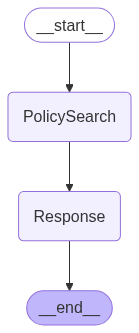

In [13]:
# Visualize using Mermaid
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [14]:
# 5. Example usage
question = "can we do work from home?"
result = graph.invoke({"question": question})
print(result["response"])


Yes, you can work from home up to 3 days a week. Full remote work requires special approval.
